547
7
Mean Absolute Error (MAE): 227.80011007971137


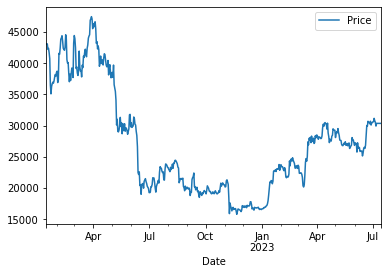

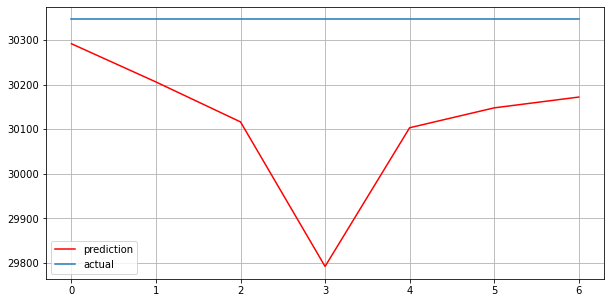

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

data = pd.read_csv("Bitcoin_kaggle.csv",
                   delimiter=';',
                   parse_dates=True,
                   index_col='Date')

print(len(data))

data = data.sort_index()

data.tail(10)
data['Price'] = data['Price'].apply(lambda x: float(x.replace(",", "")))

data = data[['Price']]

data.plot()

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

target = "Price"

def make_stationary(data):
    data_diff = data.diff().dropna()
    return data_diff

data_stationary = make_stationary(data)

def preprocess_data(data, lag_start=7, lag_end=20, test_size=0.02):
    data = pd.DataFrame(data.copy())

    test_index = int(len(data) * (1 - test_size))

    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)

    data["day"] = data.index.day

    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))

    data.drop(["day"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data_stationary, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
boosting_model.fit(X_train, y_train)
preds = boosting_model.predict(X_test)

preds_original_scale = data.iloc[-len(y_test)-1:-1].values.squeeze() + preds.cumsum()

mae = mean_absolute_error(data.iloc[-len(y_test):].values, preds_original_scale)
print(f"Mean Absolute Error (MAE): {mae}")

plt.figure(figsize=(10, 5))
plt.plot(preds_original_scale, "r", label="prediction")
plt.plot(data.iloc[-len(y_test):].values, label="actual")
plt.grid(True)
plt.legend(loc="best")

X_test['Date'] = data.index[-7:]
X_test['Price'] = preds_original_scale

X_test.set_index('Date', inplace=True)

X_test[['Price']]
X_test[['Price']].to_csv("prediction_boosting_stationary_min.csv")